<a href="https://colab.research.google.com/github/rishis123/HealthTrendsCode/blob/main/Absenteeism_NovaScotia_Proxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting absenteeism using the Nova Scotia dataset as a proxy. https://data.novascotia.ca/Public-Service/Nova-Scotia-Government-Employee-Absenteeism/3kpf-veux/data. Likely dealing with ARIMA, as it gave highest accuracy previously.

In [ ]:
import pandas as pd
json_string = 'https://data.novascotia.ca/resource/3kpf-veux.json'
df = pd.read_json(json_string)

In [ ]:
df.head()
# df.columns

,absence_date,absence_type_category,absence_type,absence_hours,employee_type,gender,age_cohort_on_absence_date
0,2014-10-22T00:00:00.000,WCB_Paid,WCB/CSST - Paid,6.25,Non-Union,Male,25 to 29
1,2014-09-02T00:00:00.000,Short_Term_Illness,Short Term Illness,7.00,Non-Union,Male,30 to 34
2,2014-09-03T00:00:00.000,Short_Term_Illness,Short Term Illness,7.00,Non-Union,Male,30 to 34
3,2014-09-04T00:00:00.000,Short_Term_Illness,Short Term Illness,7.00,Non-Union,Male,30 to 34
4,2014-09-05T00:00:00.000,Short_Term_Illness,Short Term Illness,1.00,Non-Union,Male,30 to 34


In [ ]:
#going to aggregate on date (breaking down to just date without time)

df['absence_date'] = pd.to_datetime(df['absence_date'])

df['absence_date'] = df['absence_date'].dt.strftime('%Y-%m-%d')

In [ ]:
print(df.head())


  absence_date absence_type_category        absence_type  absence_hours  \
0   2014-10-22              WCB_Paid     WCB/CSST - Paid           6.25   
1   2014-09-02    Short_Term_Illness  Short Term Illness           7.00   
2   2014-09-03    Short_Term_Illness  Short Term Illness           7.00   
3   2014-09-04    Short_Term_Illness  Short Term Illness           7.00   
4   2014-09-05    Short_Term_Illness  Short Term Illness           1.00   

  employee_type gender age_cohort_on_absence_date  
0     Non-Union   Male                   25 to 29  
1     Non-Union   Male                   30 to 34  
2     Non-Union   Male                   30 to 34  
3     Non-Union   Male                   30 to 34  
4     Non-Union   Male                   30 to 34  


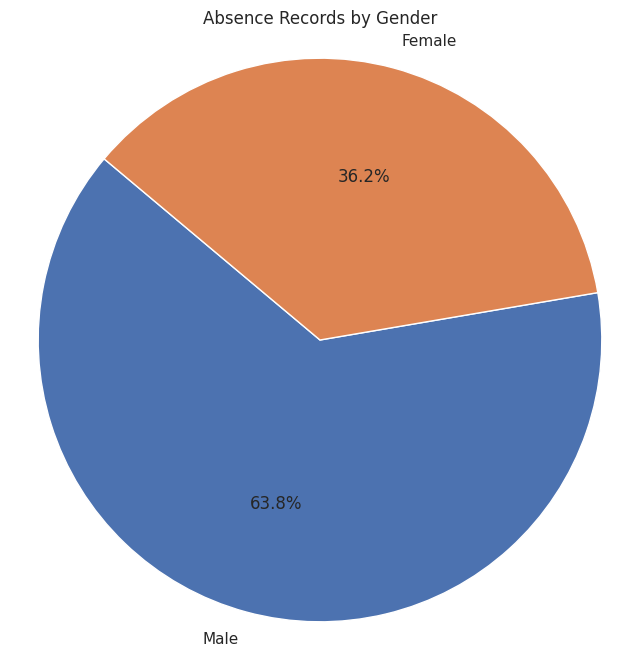

In [ ]:
#Some visualizations -- likely not using the other features for their predictive values initially.
#Each row is a different absence record, so we just visualize the number of rows with each value.
import matplotlib.pyplot as plt

#PIE CHART FOR GENDER
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Absence Records by Gender')
plt.axis('equal')
plt.show()


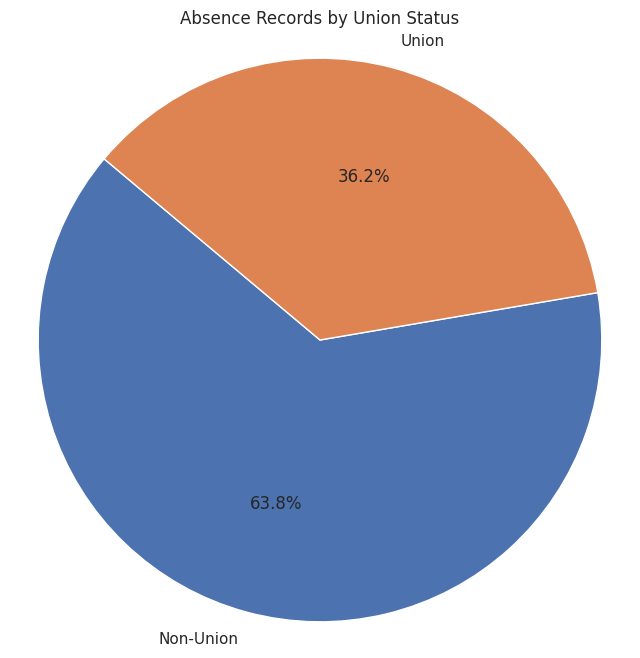

In [ ]:
#PIE CHART FOR UNION STATUS
union_counts = df['employee_type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=union_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Absence Records by Union Status')
plt.axis('equal')
plt.show()

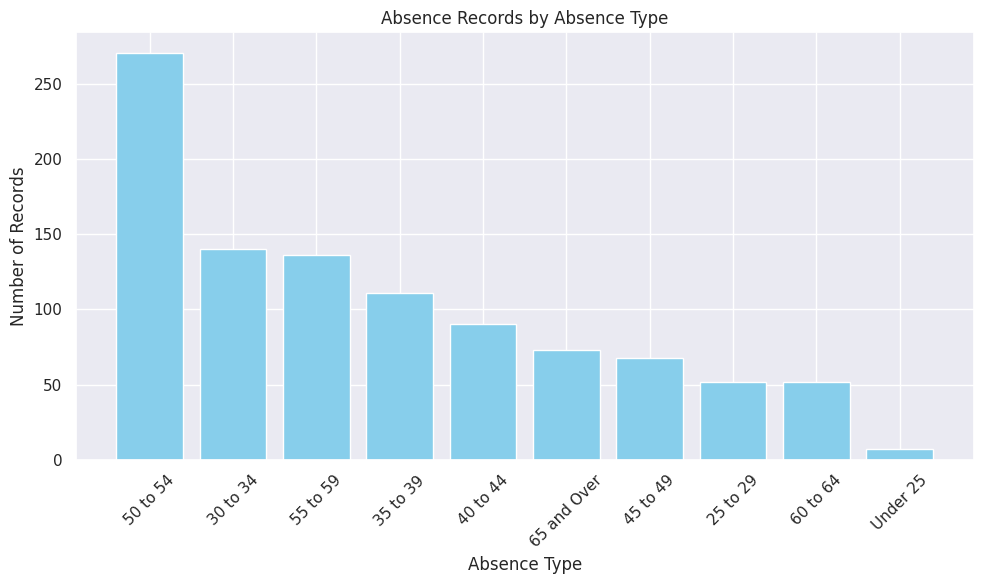

In [ ]:
#BAR GRAPH BY AGE DURING ABSENCE
age_cohort = df['age_cohort_on_absence_date'].value_counts()

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(age_cohort.index, age_cohort.values, color='skyblue')
plt.xlabel('Absence Type')
plt.ylabel('Number of Records')
plt.title('Absence Records by Absence Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

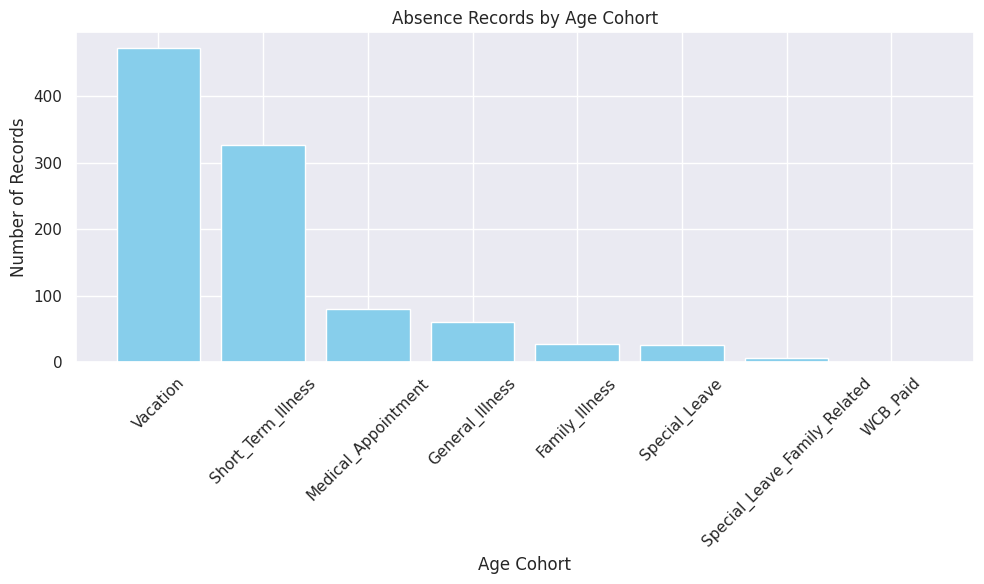

In [ ]:

#BAR GRAPH FOR ABSENCE_TYPE_CATEGORY
absence_type_counts = df['absence_type_category'].value_counts()

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(absence_type_counts.index, absence_type_counts.values, color='skyblue')
plt.xlabel('Age Cohort')
plt.ylabel('Number of Records')
plt.title('Absence Records by Age Cohort')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

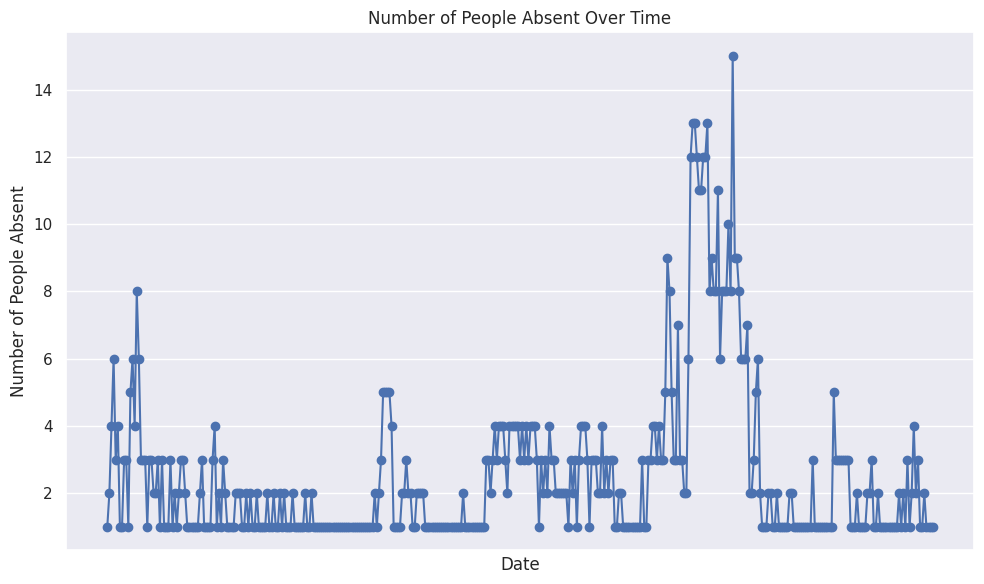

In [ ]:
#LINE GRAPH FOR ABSENCES OVER TIME
absences_per_date = df.groupby('absence_date').size()

plt.figure(figsize=(10, 6))
plt.plot(absences_per_date.index, absences_per_date.values, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Number of People Absent')
plt.title('Number of People Absent Over Time')
plt.grid(True)
plt.xticks([]) # too crowded otherwise
plt.tight_layout()
plt.show()

Now that we're done visualizing, I decided we can either predict the number of people absent on any given day, or predict the number of man-hours lost on any given day (because we have an absence_hours column). Below, I aggregate the data and visualize the latter relationship.

In [ ]:
#aggregation process
df_aggregate = df.groupby('absence_date')['absence_hours'].sum().reset_index()
df_aggregate = df_aggregate.sort_values(by='absence_date')


In [ ]:
# print(df[df['absence_date'] == '2014-04-03']) #aggregation appears correct.

    absence_date absence_type_category         absence_type  absence_hours  \
88    2014-04-03              Vacation             Vacation            4.0   
119   2014-04-03         Special_Leave             Training            7.0   
121   2014-04-03         Special_Leave             Training            8.0   
228   2014-04-03   Medical_Appointment  Medical Appointment            2.0   

    employee_type gender age_cohort_on_absence_date  
88      Non-Union   Male                   30 to 34  
119     Non-Union   Male                   25 to 29  
121     Non-Union   Male                   25 to 29  
228         Union   Male                   50 to 54  


In [ ]:
print(df_aggregate['absence_date'].tail(200)) #date is almost every week-day from April 2014 to end of May 2017

193    2016-01-21
194    2016-01-22
195    2016-01-25
196    2016-01-26
197    2016-01-27
          ...    
388    2017-03-10
389    2017-03-17
390    2017-03-20
391    2017-03-24
392    2017-03-31
Name: absence_date, Length: 200, dtype: object


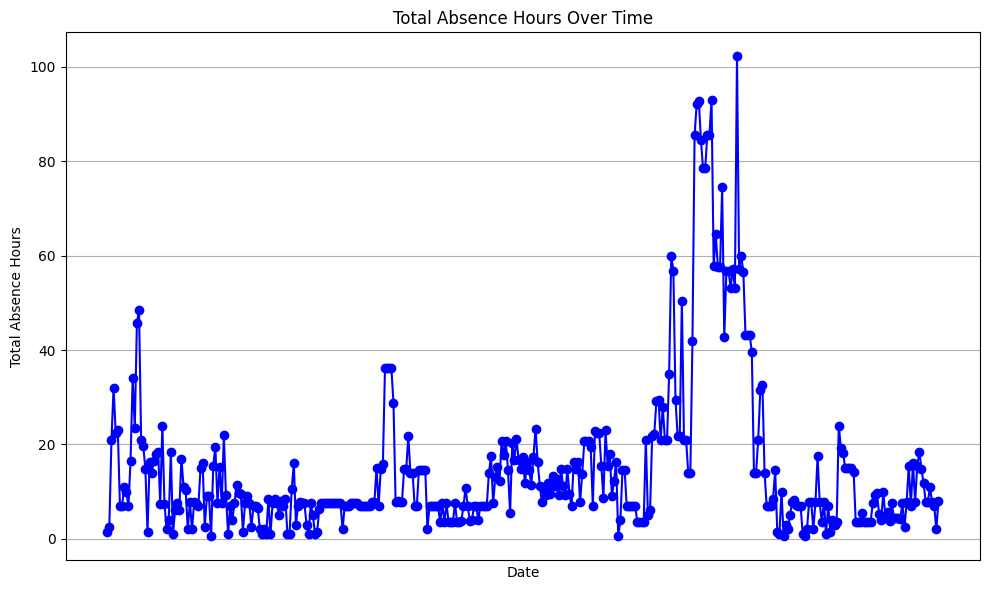

In [ ]:
import matplotlib.pyplot as plt
#LINE GRAPH FOR ABSENT_HOURS OVER TIME
plt.figure(figsize=(10, 6))
plt.plot(df_aggregate.index, df_aggregate['absence_hours'], marker='o', linestyle='-', color='b') # plot date against number of total lost man-hours on that date
plt.xlabel('Date')
plt.ylabel('Total Absence Hours')
plt.title('Total Absence Hours Over Time')
plt.grid(True)
plt.xticks([])  # too crowded -remove x-axis labels
plt.tight_layout()

plt.show()


The visualizations for total man hours lost over time and number of employees absent on any given data are quite similar, suggesting either one of them would be equally useful for predictive purposes.

Given that I've already made the df_aggregate, I'll use the man-hours lost for predictions.

In [ ]:
df_aggregate.dropna(inplace=True)
from statsmodels.tsa.stattools import adfuller

#Before calculating AIC, I check stationary-ness.
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(df_aggregate['absence_hours'])

ADF Statistic: -2.513306
p-value: 0.112270
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Non-stationary


In [ ]:
fst_diff = df_aggregate['absence_hours'].diff() #take first difference
fst_diff.dropna(inplace=True)

In [ ]:
check_stationarity(fst_diff)

ADF Statistic: -6.628395
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Stationary


We have determined when d = 1 (first-difference, the data is stationary, a requirement of ARIMA). As such, we fix a d-value of 1 in below AIC function.

As a reminder, first-difference basically means taking difference from previous value of absence_hours here for every row in the column. We fit the adfuller to this new relationship, which should be stationary as the mean is more stabilized, and seasonal patterns are removed.

In [ ]:
import itertools
import statsmodels.api as sm


# Function to find best ARIMA parameters for a given time series
def find_best_arima_parameters(time_series):
    # Define the range of p and q values (d is fixed at 1)
    p = q = range(0, 5)
    pdq = list(itertools.product(p, [1], q))

    # Initialize variables for best model selection
    best_aic = float('inf')  # Set initial best AIC to infinity (lower the better)
    best_param = None # Best possible (p, d, q) combo, but d at 1.

    # Iterate through all possible combinations of p and q
    for param in pdq:
        try:
            print(f"Testing ARIMA parameters: {param}")  # Print current parameters being tested
            # Fit ARIMA model
            model_arima = sm.tsa.ARIMA(time_series, order=param)
            model_arima_fit = model_arima.fit()

            # Update best model if current model has lower AIC
            if model_arima_fit.aic < best_aic:
                best_aic = model_arima_fit.aic
                best_param = param

        except Exception as e:
            continue

    # Return the best parameters found
    return best_param, best_aic

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_parma, best_aic = find_best_arima_parameters(df_aggregate['absence_hours'])
print(f"Best ARIMA parameters: {best_parma}")
print(f"Best AIC: {best_aic}")

Testing ARIMA parameters: (0, 1, 0)
Testing ARIMA parameters: (0, 1, 1)
Testing ARIMA parameters: (0, 1, 2)
Testing ARIMA parameters: (0, 1, 3)
Testing ARIMA parameters: (0, 1, 4)
Testing ARIMA parameters: (1, 1, 0)
Testing ARIMA parameters: (1, 1, 1)
Testing ARIMA parameters: (1, 1, 2)
Testing ARIMA parameters: (1, 1, 3)
Testing ARIMA parameters: (1, 1, 4)
Testing ARIMA parameters: (2, 1, 0)
Testing ARIMA parameters: (2, 1, 1)
Testing ARIMA parameters: (2, 1, 2)
Testing ARIMA parameters: (2, 1, 3)
Testing ARIMA parameters: (2, 1, 4)
Testing ARIMA parameters: (3, 1, 0)
Testing ARIMA parameters: (3, 1, 1)
Testing ARIMA parameters: (3, 1, 2)
Testing ARIMA parameters: (3, 1, 3)
Testing ARIMA parameters: (3, 1, 4)
Testing ARIMA parameters: (4, 1, 0)
Testing ARIMA parameters: (4, 1, 1)
Testing ARIMA parameters: (4, 1, 2)
Testing ARIMA parameters: (4, 1, 3)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (4, 1, 4)
Best ARIMA parameters: (3, 1, 3)
Best AIC: 2765.954207726866


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


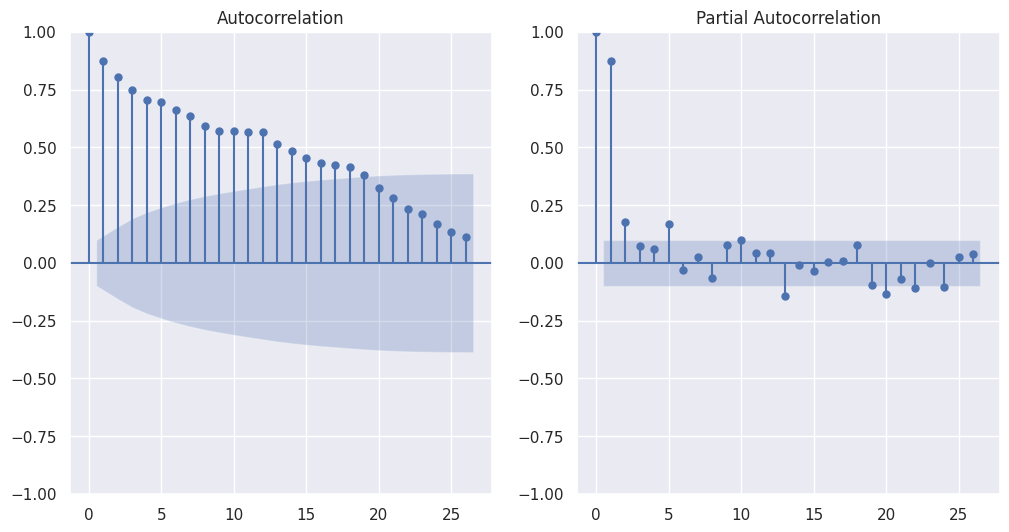

In [ ]:
# we verify with adf and pdf test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_aggregate['absence_hours'], ax=plt.gca())
plt.subplot(1, 2, 2)
plot_pacf(df_aggregate['absence_hours'], ax=plt.gca())
plt.show()

We verify AIC grid search by picking specific p, q values from ACF/PACF plots. We seek to minimize both AIC and BIC. https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling

In [ ]:
#p could be anywhere from 1 to 10 inclusive (upper cap from above article). q could be 1, 2, or 5 from PACF plot above.

import itertools
import statsmodels.api as sm

# Function to find best ARIMA parameters for a given time series
def find_best_arima_parameters(time_series):
    # Define the range of p and q values (d is fixed at 1)
    p = range(1, 11)
    q = [1, 2, 5]
    pdq = list(itertools.product(p, [1], q))

   # Initialize list to store all parameter combinations and their AIC/BIC values
    results = []

    # Iterate through all possible combinations of p and q
    for param in pdq:
        try:
            print(f"Testing ARIMA parameters: {param}")  # Print current parameters being tested
            # Fit ARIMA model
            model_arima = sm.tsa.ARIMA(time_series, order=param)
            model_arima_fit = model_arima.fit()

            # Append the parameters and their AIC/BIC to the results list
            results.append({
                "param": param,
                "aic": model_arima_fit.aic,
                "bic": model_arima_fit.bic
            })

        except Exception as e:
            continue

    # Sort results by AIC and BIC
    results_sorted_by_aic = sorted(results, key=lambda x: x["aic"])
    results_sorted_by_bic = sorted(results, key=lambda x: x["bic"])

    # Find the best parameter set that has the lowest AIC and BIC
    best_combined = None
    for result in results:
        if result["aic"] == results_sorted_by_aic[0]["aic"] and result["bic"] == results_sorted_by_bic[0]["bic"]:
            best_combined = result
            break

    if best_combined is None:
        # If no single parameter set has both the lowest AIC and BIC, choose the best overall
        best_combined = results_sorted_by_aic[0]  # or results_sorted_by_bic[0]

    # Return the best parameters found for AIC and BIC
    return best_combined

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming df_aggregate['absence_hours'] is your time series data
best_params = find_best_arima_parameters(df_aggregate['absence_hours'])
print(best_params)


Testing ARIMA parameters: (1, 1, 1)
Testing ARIMA parameters: (1, 1, 2)
Testing ARIMA parameters: (1, 1, 5)
Testing ARIMA parameters: (2, 1, 1)
Testing ARIMA parameters: (2, 1, 2)
Testing ARIMA parameters: (2, 1, 5)
Testing ARIMA parameters: (3, 1, 1)
Testing ARIMA parameters: (3, 1, 2)
Testing ARIMA parameters: (3, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (4, 1, 1)
Testing ARIMA parameters: (4, 1, 2)
Testing ARIMA parameters: (4, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (5, 1, 1)
Testing ARIMA parameters: (5, 1, 2)
Testing ARIMA parameters: (5, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (6, 1, 1)
Testing ARIMA parameters: (6, 1, 2)
Testing ARIMA parameters: (6, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (7, 1, 1)
Testing ARIMA parameters: (7, 1, 2)
Testing ARIMA parameters: (7, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (8, 1, 1)
Testing ARIMA parameters: (8, 1, 2)
Testing ARIMA parameters: (8, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (9, 1, 1)
Testing ARIMA parameters: (9, 1, 2)
Testing ARIMA parameters: (9, 1, 5)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Testing ARIMA parameters: (10, 1, 1)
Testing ARIMA parameters: (10, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Testing ARIMA parameters: (10, 1, 5)
{'param': (7, 1, 5), 'aic': 2759.3003494016207, 'bic': 2810.9267533188968}


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We proceed with these modified parameters -- (7, 1, 5)

In [ ]:
print(df_aggregate)

              absence_hours
absence_date               
2014-04-01             1.50
2014-04-02             2.50
2014-04-03            21.00
2014-04-04            32.00
2014-04-07            22.50
...                     ...
2017-03-10            11.00
2017-03-17             7.75
2017-03-20             7.00
2017-03-24             2.00
2017-03-31             8.00

[393 rows x 1 columns]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 7, 1, 5 #found above
# df_aggregate.set_index('absence_date', inplace=True) #set date to index of absence_hours
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(date_range)
df.index.name = 'absence_date'
df['absence_hours'].fillna(0, inplace=True) #Note -- to avoid confusing the ARIMA, because there is data for usually 2-4 weekdays every week, we just default missing rows on business days to 0.
#this is because the absence_hours column represents total man-hours lost, so presumably none is lost in these days.

In [ ]:
print(df_aggregate.head(50))

              absence_hours
absence_date               
2014-04-01             1.50
2014-04-02             2.50
2014-04-03            21.00
2014-04-04            32.00
2014-04-07            22.50
2014-04-08            23.00
2014-04-10             7.00
2014-04-11             7.00
2014-04-14            11.00
2014-04-15            10.00
2014-04-16             7.00
2014-04-17            16.50
2014-04-22            34.00
2014-04-23            23.50
2014-04-24            45.75
2014-04-25            48.50
2014-04-28            21.00
2014-04-29            19.75
2014-04-30            14.75
2014-05-01             1.50
2014-05-02            16.25
2014-05-05            14.00
2014-05-06            16.50
2014-05-07            18.00
2014-05-08            18.48
2014-05-09             7.48
2014-05-12            23.98
2014-05-13             7.48
2014-05-14             2.00
2014-05-15             4.00
2014-05-16            18.50
2014-05-20             1.00
2014-05-21             6.00
2014-05-22          

In [ ]:
df_aggregate['absence_hours_diff'] = df_aggregate['absence_hours'].diff() #we take first difference of dataset and store it
df_aggregate.dropna(inplace=True) #drop first row -- goes to N/A
print(df_aggregate.head(50))

              absence_hours  absence_hours_diff
absence_date                                   
2014-04-02             2.50                1.00
2014-04-03            21.00               18.50
2014-04-04            32.00               11.00
2014-04-07            22.50               -9.50
2014-04-08            23.00                0.50
2014-04-10             7.00              -16.00
2014-04-11             7.00                0.00
2014-04-14            11.00                4.00
2014-04-15            10.00               -1.00
2014-04-16             7.00               -3.00
2014-04-17            16.50                9.50
2014-04-22            34.00               17.50
2014-04-23            23.50              -10.50
2014-04-24            45.75               22.25
2014-04-25            48.50                2.75
2014-04-28            21.00              -27.50
2014-04-29            19.75               -1.25
2014-04-30            14.75               -5.00
2014-05-01             1.50             

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

window_size = 5 * 7  # 5 weeks of training data -- sliding window approach
forecast_period = 7  # 1 week forecast ahead.

# Initialize lists to store results
forecasts = []
actuals = []

# Sliding window approach
for start in range(len(df_aggregate) - window_size - forecast_period + 1):
    end = start + window_size
    train = df_aggregate['absence_hours'][start:end]
    test = df_aggregate['absence_hours'][end:end + forecast_period]

    # Fit the ARIMA model
    p, d, q = 7, 1, 5  # Example parameters, replace with your optimal values
    model = ARIMA(train, order=(p, d, q)) #Note -- don't actually use absence_hours_diff, since this takes first difference already, so don't want to do it twice.
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_period) #forecasts for the next 7 days based on train data of 5 weeks (35 days)
    forecasts.extend(forecast)
    actuals.extend(test)
    #We will have two lists -- one with the true value of those 7 days, and the other with the predicted value.

#Dates for all forecasts, aligned with business days
forecast_dates = pd.date_range(start=df_aggregate.index[window_size], periods=forecast_period * (len(forecasts) // forecast_period), freq='B')

forecast_series = pd.Series(forecasts, index=forecast_dates)
actual_series = pd.Series(actuals, index=df_aggregate.index[window_size:window_size + len(actuals)]) #We predict from the 35th day onwards.


plt.figure(figsize=(14, 7))
plt.plot(df['absence_hours'], label='Historical Data')
plt.plot(actual_series, label='Actual Data', color='green')
plt.plot(forecast_series, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Absence Hours')
plt.title('Forecast 1 week ahead Nova Scotia')
plt.legend()
plt.show()

# Calculate and print performance metrics
mse = mean_squared_error(actuals, forecasts)
print(f'Mean Squared Error: {mse}')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib

ValueError: Length of values (2457) does not match length of index (357)

In [ ]:
print(f'Length of forecasts: {len(forecasts)}')
print(f'Length of actuals: {len(actuals)}')


Length of forecasts: 2457
Length of actuals: 2457


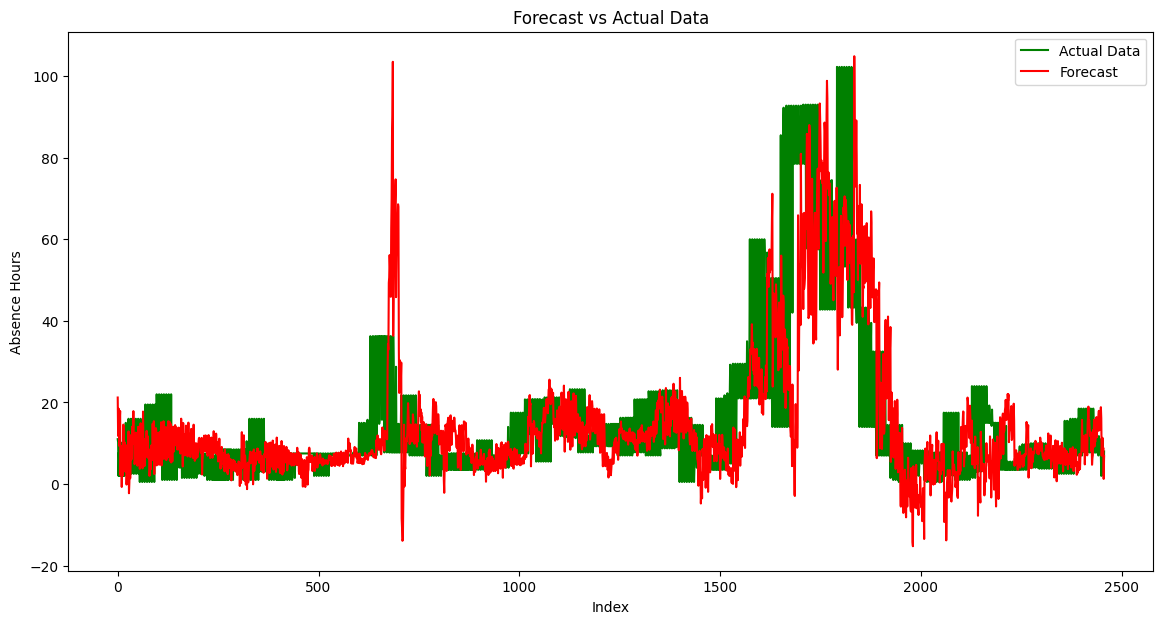

Mean Squared Error: 207.18270974367252
R^2 Value: 0.34847310741991644


In [ ]:
from sklearn.metrics import r2_score

index_range = range(len(forecasts)) #will be from 0 to 2456
forecast_series = pd.Series(forecasts, index=index_range)
actual_series = pd.Series(actuals, index=index_range)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(index_range, actual_series, label='Actual Data', color='green')
plt.plot(index_range, forecast_series, label='Forecast', color='red')
plt.xlabel('Index')
plt.ylabel('Absence Hours')
plt.title('Forecast vs Actual Data')
plt.legend()
plt.show()

# Calculate and print performance metrics
mse = mean_squared_error(actuals, forecasts)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(actuals, forecasts)
print(f'R^2 Value: {r2}')



We try this with more data -- 10 weeks beforehand.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

window_size = 10 * 7  # 10 weeks of training data -- sliding window approach
forecast_period = 7  # 1 week forecast ahead.

# Initialize lists to store results
forecasts_10week = []
actuals_10week = []

# Sliding window approach
for start in range(len(df_aggregate) - window_size - forecast_period + 1):
    end = start + window_size
    train = df_aggregate['absence_hours'][start:end]
    test = df_aggregate['absence_hours'][end:end + forecast_period]

    # Fit the ARIMA model
    p, d, q = 7, 1, 5  # Example parameters, replace with your optimal values
    model = ARIMA(train, order=(p, d, q)) #Note -- don't actually use absence_hours_diff, since this takes first difference already, so don't want to do it twice.
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_period) #forecasts for the next 7 days based on train data of 10 weeks (70 days)
    forecasts_10week.extend(forecast)
    actuals_10week.extend(test)
    #We will have two lists -- one with the true value of those 7 days, and the other with the predicted value.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [ ]:
print(f'Length of forecasts: {len(forecasts_10week)}')
print(f'Length of actuals: {len(actuals_10week)}')


Length of forecasts: 2212
Length of actuals: 2212


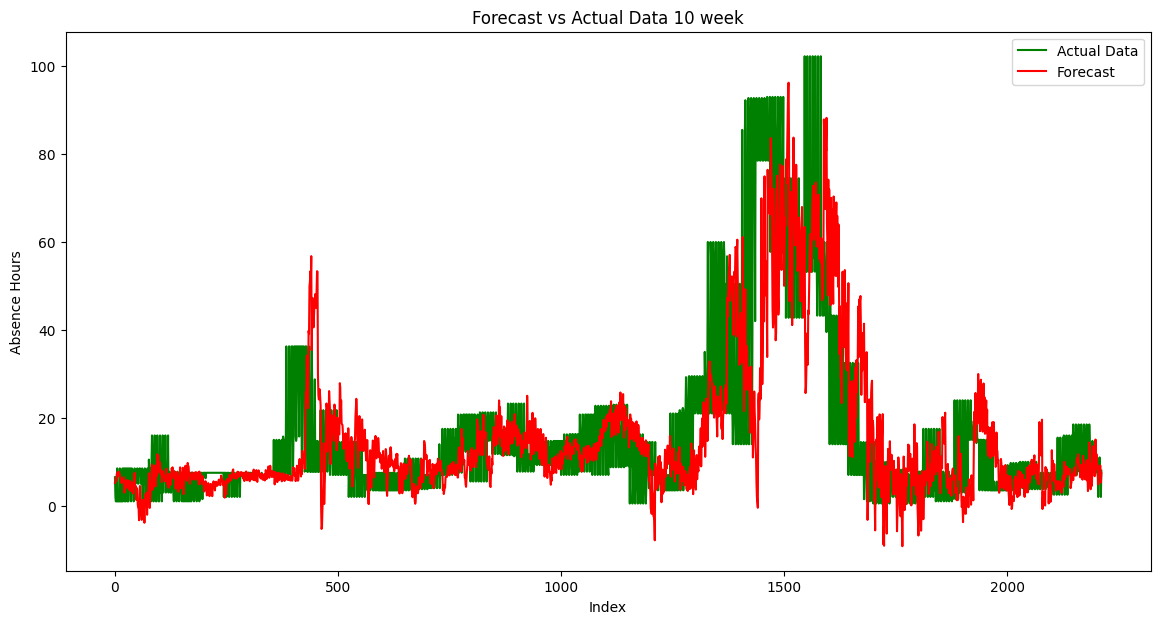

Mean Squared Error: 195.01754806193875
R^2 Value: 0.4329716345777297


In [ ]:
index_range = range(len(forecasts_10week)) #will be from 0 to 2456
forecast_series_10week = pd.Series(forecasts_10week, index=index_range)
actual_series_10week = pd.Series(actuals_10week, index=index_range)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(index_range, actual_series_10week, label='Actual Data', color='green')
plt.plot(index_range, forecast_series_10week, label='Forecast', color='red')
plt.xlabel('Index')
plt.ylabel('Absence Hours')
plt.title('Forecast vs Actual Data 10 week')
plt.legend()
plt.show()

# Calculate and print performance metrics
mse = mean_squared_error(actuals_10week, forecasts_10week)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(actuals_10week, forecasts_10week)
print(f'R^2 Value: {r2}')

In [ ]:
print(df_aggregate.tail(50))

              absence_hours  absence_hours_diff
absence_date                                   
2016-12-29             3.00               -1.00
2017-01-03             3.50                0.50
2017-01-04            24.00               20.50
2017-01-05            19.25               -4.75
2017-01-06            18.25               -1.00
2017-01-09            15.00               -3.25
2017-01-10            15.00                0.00
2017-01-11            15.00                0.00
2017-01-12            15.00                0.00
2017-01-13            14.25               -0.75
2017-01-17             3.50              -10.75
2017-01-18             3.50                0.00
2017-01-19             3.50                0.00
2017-01-20             5.50                2.00
2017-01-23             3.50               -2.00
2017-01-24             3.50                0.00
2017-01-25             3.50                0.00
2017-01-26             3.50                0.00
2017-01-27             7.50             